# Code to analyse cross-correlations between areas

Adrian 2023-09-08

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd
import xarray as xr
import importlib

from data import load_data, ecephys
from analysis import clustering as cl
from plotting import matrix as plt_m

In [2]:
# load and save all sessions to files
good_sessions = [1053925378, 1081090969, 1064415305, 1108334384, 1115356973]
cache = load_data.load_cache_behavior_neuropixel()

### Create local files to speed up loading data later

In [3]:
# from tqdm import tqdm
# for session_id in tqdm(good_sessions):
    
#     session = cache.get_ecephys_session(session_id)
#     trial_df = load_data.get_trial_df(session)
    
#     from data import load_data, ecephys
#     data_xr, units = ecephys.easy_spike_matrix_and_unit_table(cache, session,
#                                                              with_layer=True)

#     # sort dataframe for nice plotting
#     units = units.sort_values(by = ['area_int', 'easy_layer'], na_position = 'last')

#     # remove units in other category
#     units = units.query('area_int < 7')
#     data_xr = data_xr.loc[ units.index, : ]
    
#     ### save data to disk
#     file = '../analysis_data/data_xr_{}.h5'.format(session_id)
#     data_xr.to_netcdf(file)

#     # save with default index
#     units_save = units.copy()
#     units_save = units_save.reset_index()

#     file = '../analysis_data/units_{}.feather'.format(session_id)
#     units_save.to_feather(file)

#     file = '../analysis_data/trial_df_{}.feather'.format(session_id)
#     trial_df_save = trial_df.copy()
#     trial_df_save = trial_df_save.reset_index()
#     trial_df_save.to_feather(file)   

### Plot behavior of mouse

In [4]:
session_id = good_sessions[0]
data_xr, units, trial_df = ecephys.load_local_files(session_id)

In [5]:
session = cache.get_ecephys_session(session_id)

In [6]:
from plotting import behavior as plt_b

(155.0, 180.0)

<Figure size 640x480 with 0 Axes>

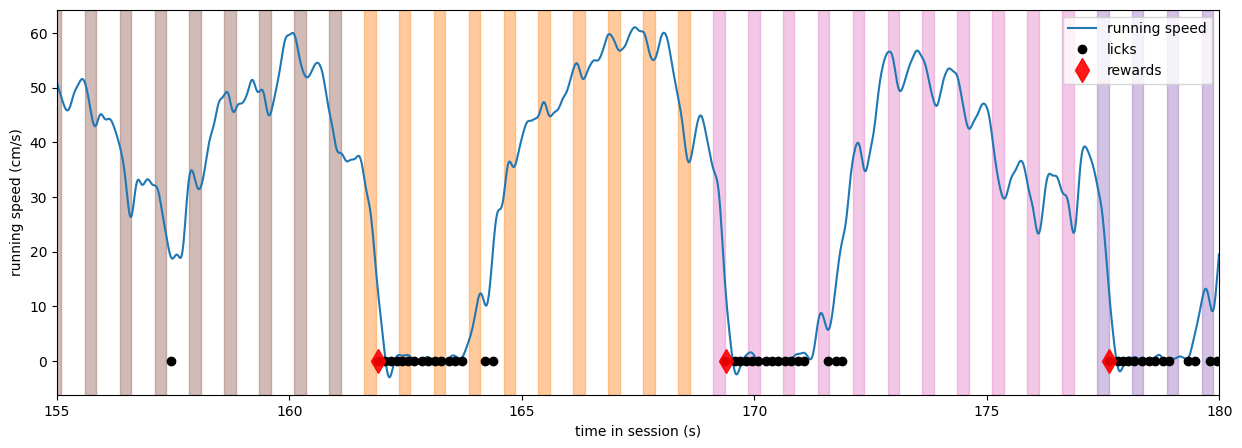

In [7]:
initial_time = 155 # initial time for plot, in seconds
final_time = 180 # final time for plot, in seconds

plt.clf()
fig, ax = plt.subplots(figsize = (15,5))
plt_b.plot_behavior_all(ax, session, initial_time, final_time)
ax.legend(['running speed', 'licks', 'rewards'])

ax.set_ylabel('running speed (cm/s)')
ax.set_xlabel('time in session (s)')
ax.set_xlim(initial_time, final_time)

### Plot sorted neural activity together with behavior

In [8]:
t_min = 157
t_max = 167

select = (data_xr.time > t_min) & (data_xr.time < t_max)

spks = data_xr[:,select]
time = data_xr.time[select]
nr_units = spks.shape[0]

In [9]:
# cluster by area
sort_sel =  (data_xr.time > 300) & (data_xr.time < 500)
sorted_ids = cl.cluster_by_area(data_xr[:,sort_sel], units, sort_by_area=True)
# sorted_ids = np.random.permutation( sorted_ids )
# sorted_ids = data_xr.unit_id

In [10]:
from scipy.ndimage import gaussian_filter1d
plt.rcParams.update({'font.size': 18})

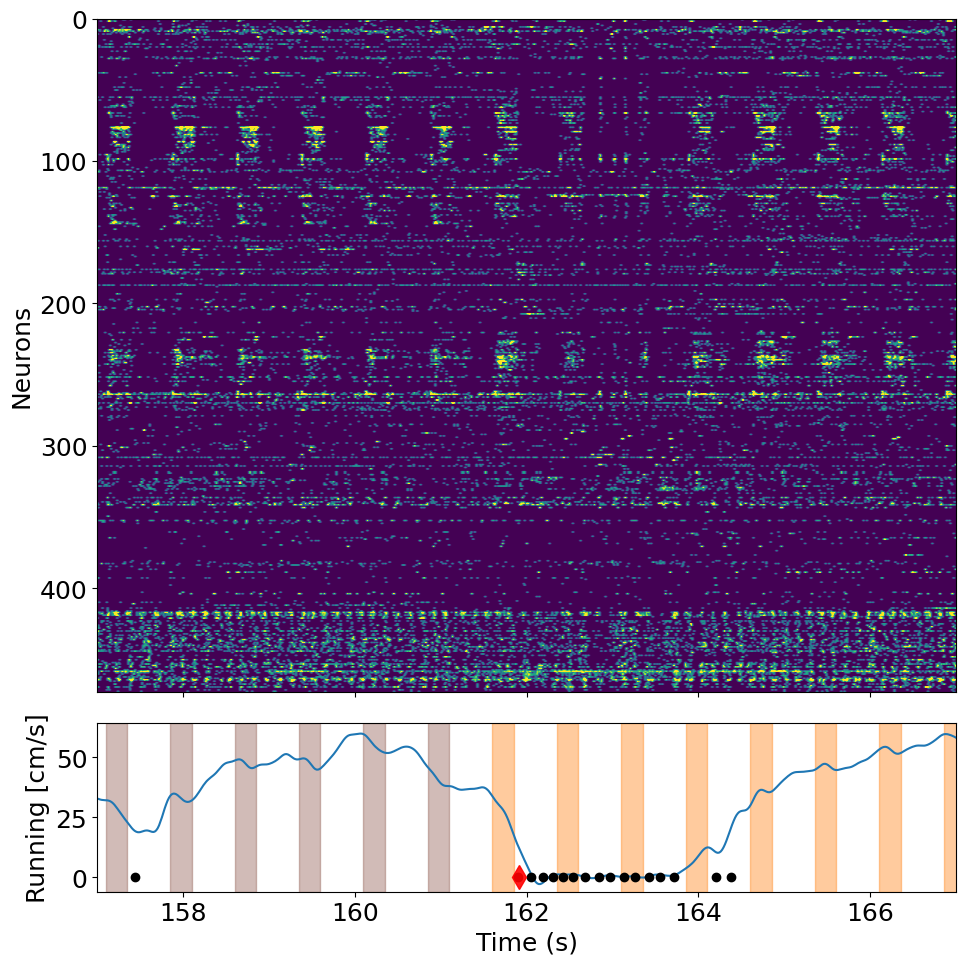

In [11]:
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]},
                             sharex=True, figsize=(10,10))  

sig = gaussian_filter1d(spks.loc[sorted_ids].astype(float), axis=1, sigma=1)

ax0.imshow( sig,
           interpolation= 'antialiased', vmin=0, vmax=0.8, aspect='auto',
           extent=(t_min, t_max, nr_units-0.5,0.5), cmap='viridis' )
ax0.set_ylim(nr_units-0.5,0.5)
ax0.set_ylabel('Neurons')
ax0.set_yticks([0,100,200,300,400])

# plot behavior
plt_b.plot_behavior_all(ax1, session, initial_time, final_time)
# ax1.legend(['running speed', 'licks', 'rewards'])

ax1.set_ylabel('Running [cm/s]')
ax1.set_xlabel('Time (s)')
ax1.set_xlim(t_min, t_max)
ax1.grid(False)

plt.tight_layout()

In [12]:
dt = 5320.456657 - 157.849845   # from differences in same trial id
t_min = initial_time+dt
t_max = final_time+dt

select = (data_xr.time > t_min) & (data_xr.time < t_max)
spks = data_xr[:,select]
time = data_xr.time[select]
nr_units = spks.shape[0]

In [13]:
sorted_ids_p = cl.cluster_by_area(spks, units, sort_by_area=True)

(-8.0, 70.0)

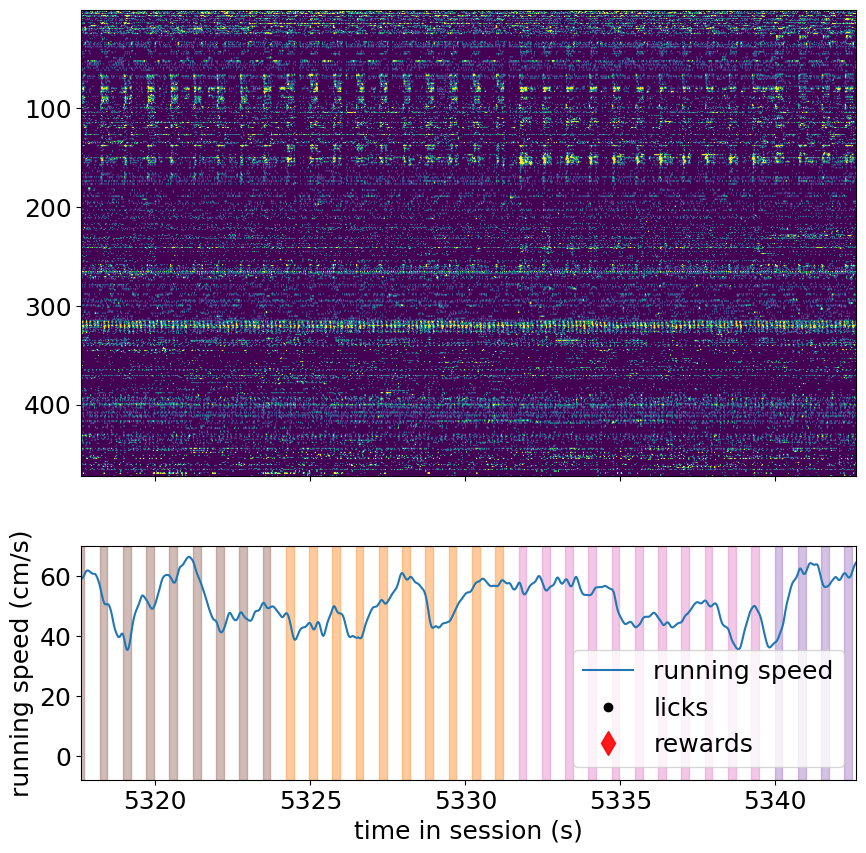

In [14]:
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]},
                             sharex=True, figsize=(10,10))  

ax0.imshow( spks.loc[sorted_ids_p], interpolation= 'antialiased', vmax=0.8, aspect='auto',
           extent=(t_min, t_max, nr_units-0.5,0.5) )
ax0.set_ylim(nr_units-0.5,0.5)

# plot behavior
plt_b.plot_behavior_all(ax1, session, t_min, t_max)
ax1.legend(['running speed', 'licks', 'rewards'])

ax1.set_ylabel('running speed (cm/s)')
ax1.set_xlabel('time in session (s)')
ax1.set_xlim(t_min, t_max)
ax1.set_ylim(-8, 70)

### Calculate firing rates across conditions

In [15]:
all_df = session.stimulus_presentations
pres_df = all_df.loc[(all_df.stimulus_block==0)|(all_df.stimulus_block==5)]
# pres_df

In [16]:
stim_xr = ecephys.get_stim_xarray_all(pres_df, data_xr,
                                      start_dt=0, end_dt=0.5)



In [17]:
active_id = trial_df.query('active==True').index
passive_id = trial_df.query('active==False').index

ac = pres_df.query('active == True')
ch = ac[ ac['is_change'] == True]
change_active_id = ch.index

ac = pres_df.query('active == False')
ch = ac[ ac['is_change'] == True]
change_passive_id = ch.index

In [18]:
dd = dict(act_before = active_id,
     pas_before = passive_id,
     act_change = change_active_id,
     pas_change = change_passive_id)

In [19]:
l = list()
for key in dd:
    data = stim_xr.loc[ dd[key].values ]
    mean = data.mean(['stim_id', 'time']) * 100   # to Hz
    df = pd.DataFrame( mean, index=mean.unit_id, columns = [key] )
    l.append( df )

In [20]:
units_ap = pd.concat(objs=[*l, units], axis=1)
units_ap.index.name = 'u_id'
units_ap['u_id'] = units_ap.index

In [21]:
units_ap

act_before  pas_before  act_change  pas_change     unit_id  \
u_id                                                                     
1060220302    2.777056   10.885281       3.040      11.480  1060220302   
1060220334   11.770563   14.212121       9.560      13.040  1060220334   
1060220314   12.839827   18.820346      11.896      16.808  1060220314   
1060220488   15.826840   13.487013      16.072      13.744  1060220488   
1060220273    0.532468    0.281385       0.640       0.256  1060220273   
...                ...         ...         ...         ...         ...   
1060220362   26.571429   23.887446      27.496      23.168  1060220362   
1060220393    8.632035    7.491342       8.704       8.160  1060220393   
1060220375    2.469697    3.530303       1.456       4.000  1060220375   
1060220363    4.794372    3.952381       3.512       4.896  1060220363   
1060220370    4.030303    5.712121       4.192       6.880  1060220370   

           structure_acronym easy_name  area_int easy_layer cortical_layer  \
u_id                                                                         
1060220302               LGd       LGN         0       None           None   
1060220334               LGd       LGN         0       None           None   
1060220314               LGd       LGN         0       None           None   
1060220488               LGd       LGN         0       None           None   
1060220273               LGd       LGN         0       None           None   
...                      ...       ...       ...        ...            ...   
1060220362                DG        HP         6       None           None   
1060220393               CA1        HP         6       None           None   
1060220375               CA1        HP         6       None           None   
1060220363                DG        HP         6       None           None   
1060220370                DG        HP         6       None           None   

            firing_rate  peak_channel_id  probe_vertical_position  \
u_id                                                                
1060220302     6.767898       1060218275                    620.0   
1060220334    11.433687       1060218291                    780.0   
1060220314    14.803913       1060218282                    700.0   
1060220488    14.177467       1060218260                    480.0   
1060220273     0.365711       1060218260                    480.0   
...                 ...              ...                      ...   
1060220362    23.990850       1060218329                   1160.0   
1060220393     7.778285       1060218390                   1740.0   
1060220375     4.235871       1060218361                   1460.0   
1060220363     5.704523       1060218330                   1160.0   
1060220370     4.997042       1060218341                   1260.0   

            anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
u_id                                                                           
1060220302                             7933.0                         3217.0   
1060220334                             7900.0                         3050.0   
1060220314                             7919.0                         3145.0   
1060220488                             7965.0                         3379.0   
1060220273                             7965.0                         3379.0   
...                                       ...                            ...   
1060220362                             7819.0                         2626.0   
1060220393                             7690.0                         1958.0   
1060220375                             7754.0                         2282.0   
1060220363                             7815.0                         2605.0   
1060220370                             7794.0                         2492.0   

            left_right_ccf_coordinate     FS        u_id  
u_id                                

In [22]:
melt = pd.melt(units_ap, id_vars='unit_id', value_vars=list(dd.keys()), value_name='rate_Hz', var_name='state')
melt_df = pd.merge(left=melt, right=units_ap, on='unit_id')

<AxesSubplot:xlabel='easy_name', ylabel='rate_Hz'>

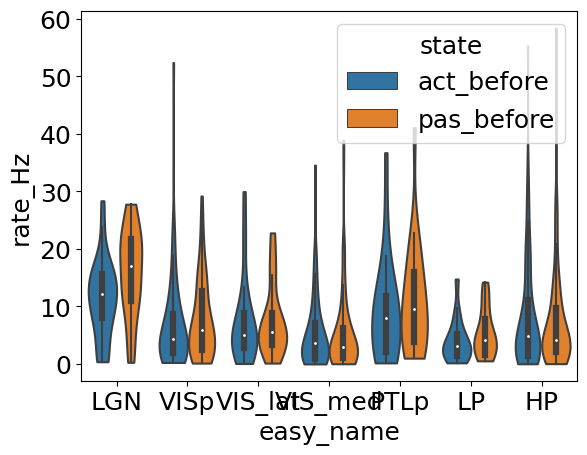

In [23]:
plt.figure()

area_order = ['LGN', 'VISp', 'VIS_lat', 'VIS_med', 'PTLp', 'LP', 'HP']

import seaborn as sns
sns.violinplot( data=melt_df , x='easy_name', y='rate_Hz', hue='state',
          order=area_order, hue_order=['act_before', 'pas_before'], cut=0)

<AxesSubplot:xlabel='easy_name', ylabel='rate_Hz'>

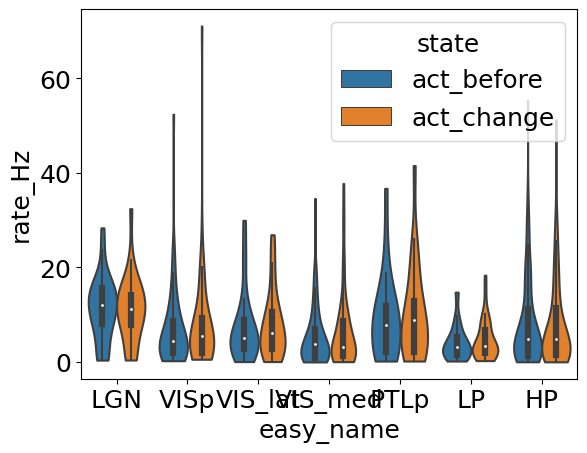

In [24]:
plt.figure()

area_order = ['LGN', 'VISp', 'VIS_lat', 'VIS_med', 'PTLp', 'LP', 'HP']

import seaborn as sns
sns.violinplot( data=melt_df , x='easy_name', y='rate_Hz', hue='state',
          order=area_order, hue_order=['act_before', 'act_change'], cut=0)

### Compare correlation structure

In [25]:
avg_merge, merge_ds, image_int, active_period = ecephys.create_nice_xarrays(
    trial_df, data_xr, return_val='merge_ds')

In [26]:
n_merge = merge_ds.transpose("unit_id", "stim_id", "time")

# calculate correlation
active = n_merge[:,active_period,:].stack( merge_time=('stim_id', 'time') )
passive = n_merge[:,~active_period,:].stack( merge_time=('stim_id', 'time') )

# sort by signal correlation from above
# sort_idx = sort_avg_sig
sort_idx = cl.cluster_by_area( active, units, sort_by_area=True )
# sort_idx = cl.cluster_by_area( passive, units, sort_by_area=True)
# sort_idx = active.unit_id
active = active.loc[sort_idx]
passive = passive.loc[sort_idx]

# calculate noise correlations
cc_a = np.corrcoef( active )
cc_p = np.corrcoef( passive )

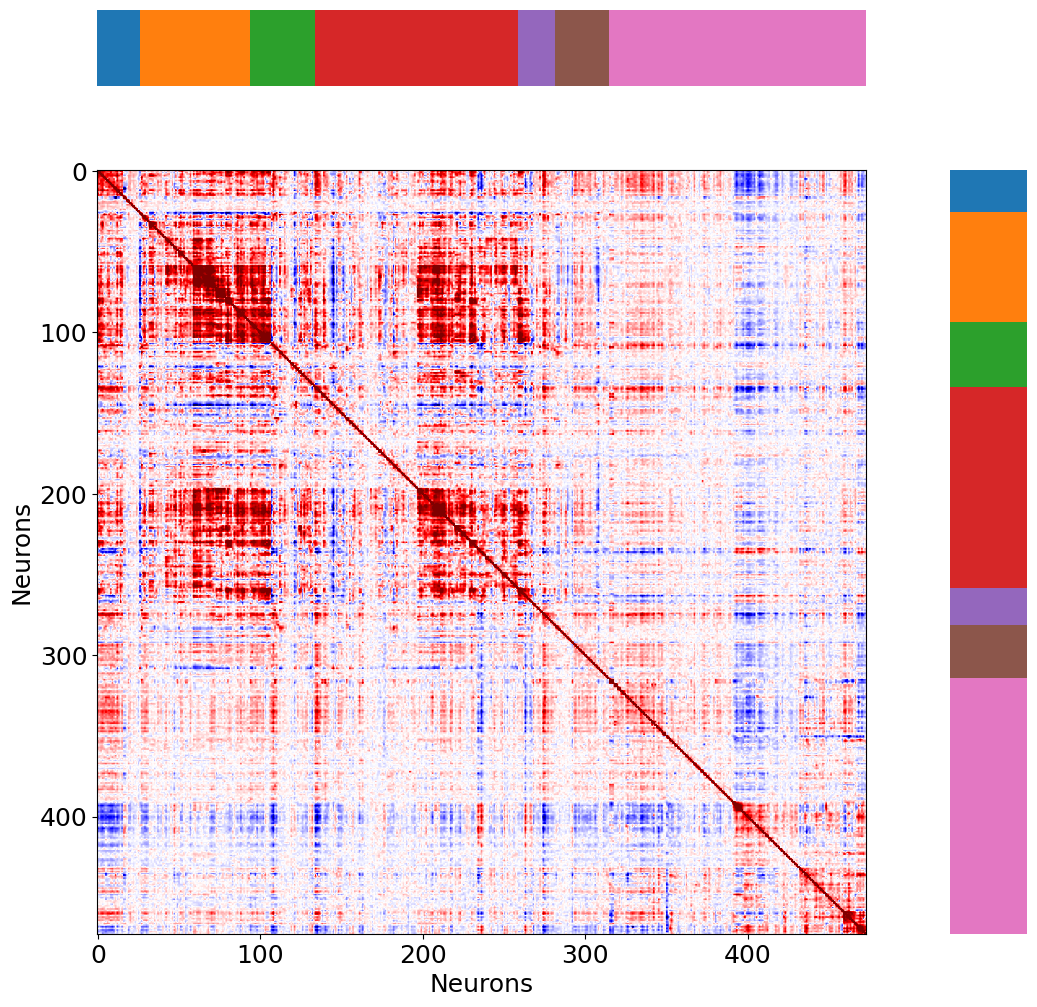

In [27]:
plt_m.plot_cor_with_areas( cc_a, active, units )

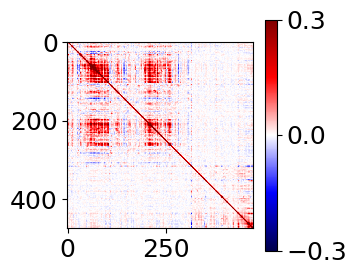

In [28]:
plt.figure(figsize=(3,3))
plt.imshow(cc_p, vmin=-0.3, vmax=0.3, cmap='seismic')
plt.colorbar(ticks=[-0.3,0,0.3])

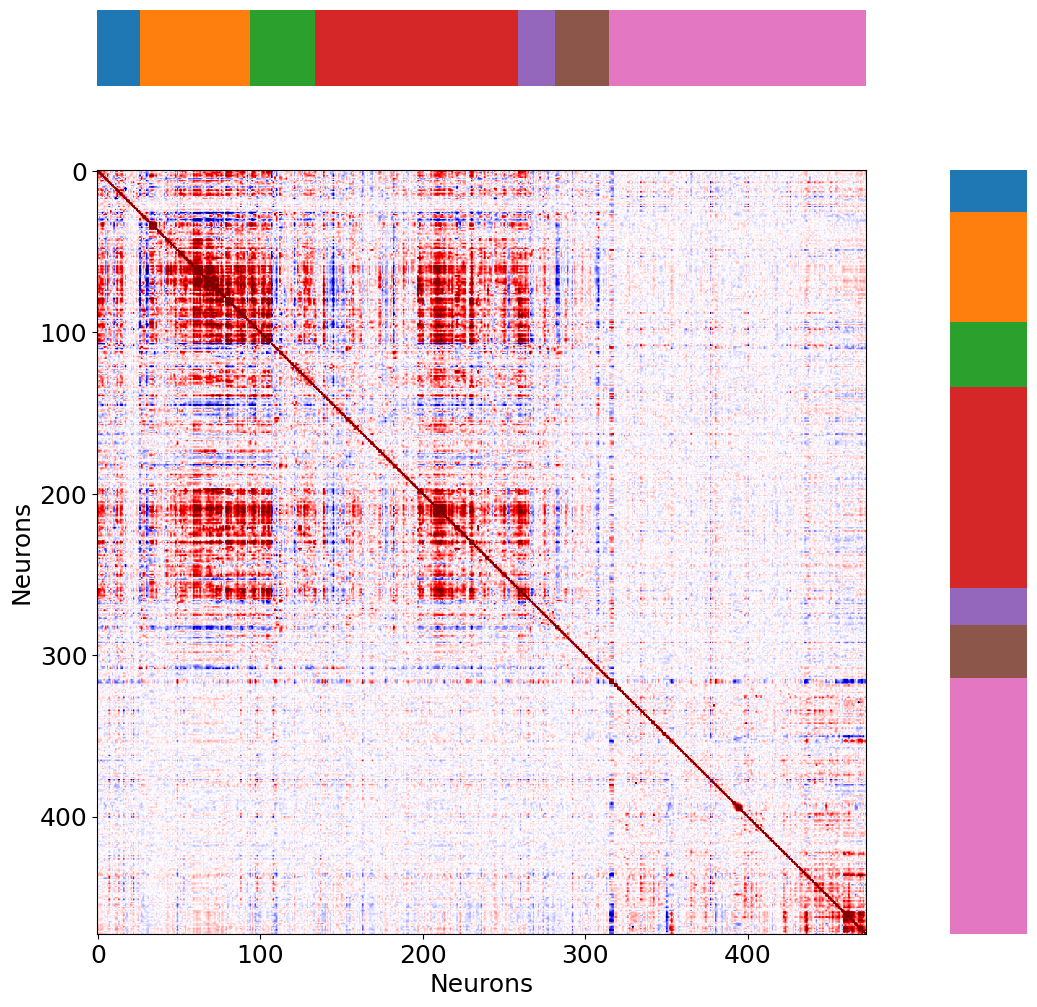

In [29]:
plt_m.plot_cor_with_areas( cc_p, passive, units )

In [30]:
area_int = units.loc[ active.unit_id ].area_int

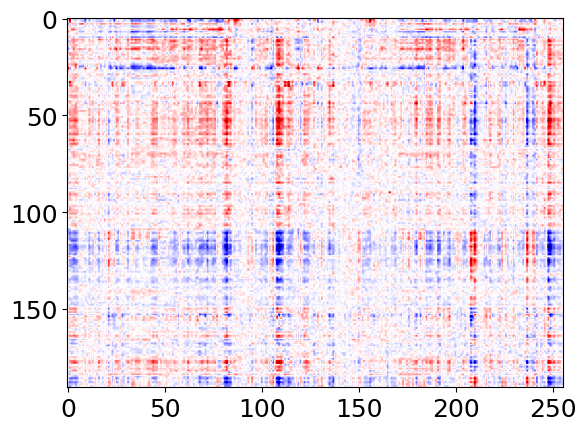

In [31]:
plt.figure()

cortex = (area_int > 0) & (area_int < 5)
subcort = (area_int == 5) | (area_int == 6)

sel_a = cc_a[ subcort, :][:,cortex]
scale = 0.3
plt.imshow( sel_a, vmin=-scale, vmax=scale,
                  cmap='seismic', aspect='auto')

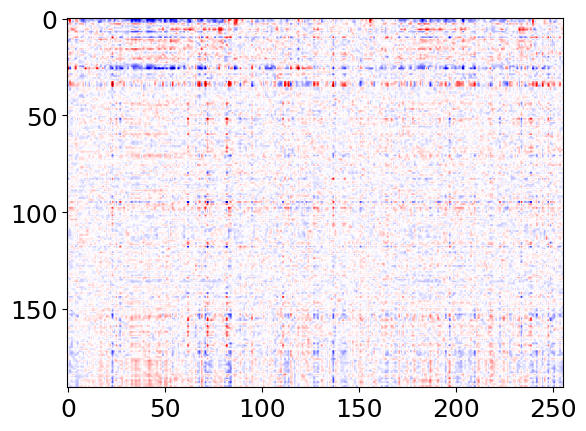

In [32]:
sel_p = cc_p[ subcort, :][:,cortex]
scale = 0.3
plt.imshow( sel_p, vmin=-scale, vmax=scale,
                  cmap='seismic', aspect='auto')

In [33]:
### Compute participation ratio
U_a, S_a, Vh_a = np.linalg.svd(sel_a, full_matrices=True)
U_p, S_p, Vh_p = np.linalg.svd(sel_p, full_matrices=True)

In [34]:
rank1 = np.outer( U_a[:,0] * S_a[0], Vh_a[0,:] )

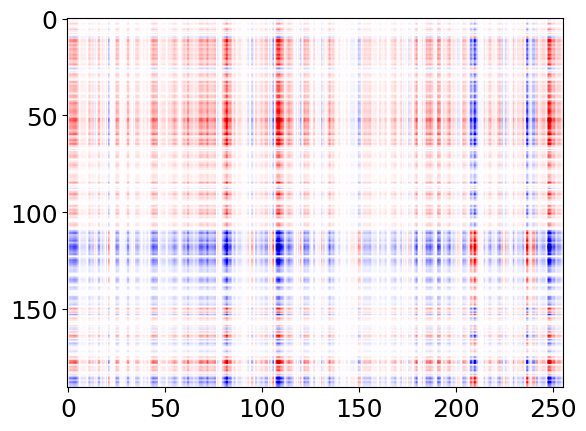

In [35]:
plt.imshow(rank1, vmin=-scale, vmax=scale,
                  cmap='seismic', aspect='auto')

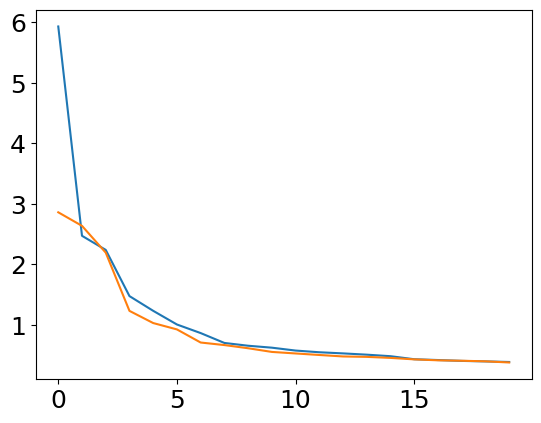

In [36]:
plt.figure()
plt.plot(S_a[0:20])
plt.plot(S_p[0:20])

In [37]:
area_int = units.loc[ active.unit_id ].area_int

cor_by_area_a = cl.calc_mean_per_area(cc_a, area_int)
cor_by_area_p = cl.calc_mean_per_area(cc_p, area_int)

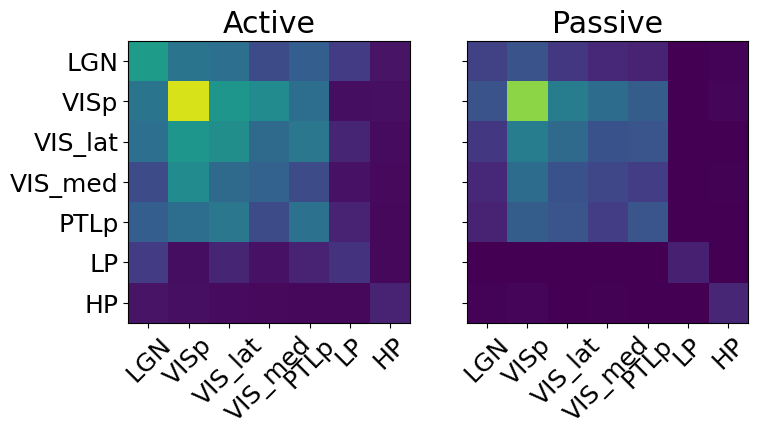

In [38]:
scale = 0.1
plt_m.plot_two_mat_with_areas(cor_by_area_a, cor_by_area_p)

### For multiple sessions

In [39]:
results_df = list()
result_act = list()
result_pas = list()

for session_id in good_sessions:

    data_xr, units, trial_df = ecephys.load_local_files(session_id)
    avg_merge, merge_noise, image_int, active_period = ecephys.create_nice_xarrays(
        trial_df, data_xr, return_val='merge_ds')

    # separate active and passive period, transform into time dimension
    n_merge = merge_noise.transpose("unit_id", "stim_id", "time")
    
    active = n_merge[:,active_period,:].stack( merge_time=('stim_id', 'time') )
    passive = n_merge[:,~active_period,:].stack( merge_time=('stim_id', 'time') )
    
    cc_a = np.corrcoef( active )
    cc_p = np.corrcoef( passive )

    area_int = units.loc[ active.unit_id ].area_int

    cor_by_area_a = cl.calc_mean_per_area(cc_a, area_int, absolute=True)
    cor_by_area_p = cl.calc_mean_per_area(cc_p, area_int, absolute=True)

    scale = 0.1
    # sns.set(font_scale=2)
    # plt_m.plot_two_mat_with_areas(cor_by_area_a, cor_by_area_p)
    
    N = cor_by_area_a.shape[0]
    sel_upper = np.triu( np.ones((N,N)), k=1) == 1
    sel_eye = np.eye(N) == 1
    
    cortex = (area_int > 0) & (area_int < 5)
    subcort = (area_int == 5) | (area_int == 6)
    
    cc_a = np.abs(cc_a)
    cc_p = np.abs(cc_p)
    
    results = dict(session_id = session_id,
                   active_across = np.mean( cor_by_area_a[sel_upper] ),
                   passive_across = np.mean( cor_by_area_p[sel_upper] ),
                   active_within = np.mean( cor_by_area_a[sel_eye] ),
                   passive_within = np.mean( cor_by_area_p[sel_eye] ),
                   
                   active_cc = np.mean( cc_a[ cortex, :][:,cortex] ),
                   passive_cc = np.mean( cc_p[ cortex, :][:,cortex] ),
                   active_cs = np.mean( cc_a[ subcort, :][:,cortex] ),
                   passive_cs = np.mean( cc_p[ subcort, :][:,cortex] ),
                  )
    results_df.append( results )
    result_act.append( cor_by_area_a )
    result_pas.append( cor_by_area_p )
    
results_df = pd.DataFrame( results_df )
result_act = np.stack( result_act )
result_pas = np.stack( result_pas )

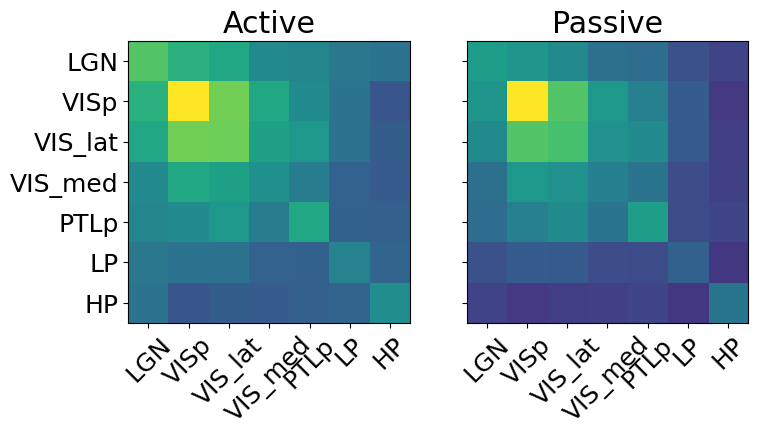

In [40]:
plt_m.plot_two_mat_with_areas(np.mean(result_act, axis=0),
                              np.mean(result_pas, axis=0), scale=0.1 )

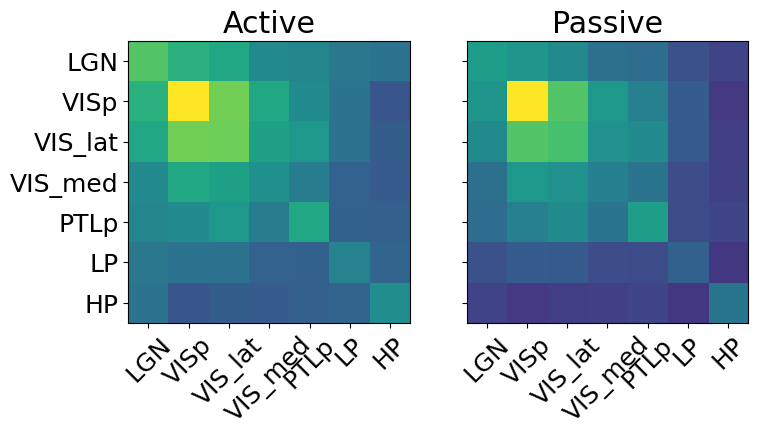

In [41]:
plt_m.plot_two_mat_with_areas(np.mean(result_act, axis=0),
                              np.mean(result_pas, axis=0) )

### Quantify changes

In [42]:
mm = {1053925378: 'Mouse 1',
1064415305: 'Mouse 2',
1081090969: 'Mouse 3',
1108334384: 'Mouse 4',
1115356973: 'Mouse 5',}

Text(138.45312499999997, 0.5, 'Absolute correlation')

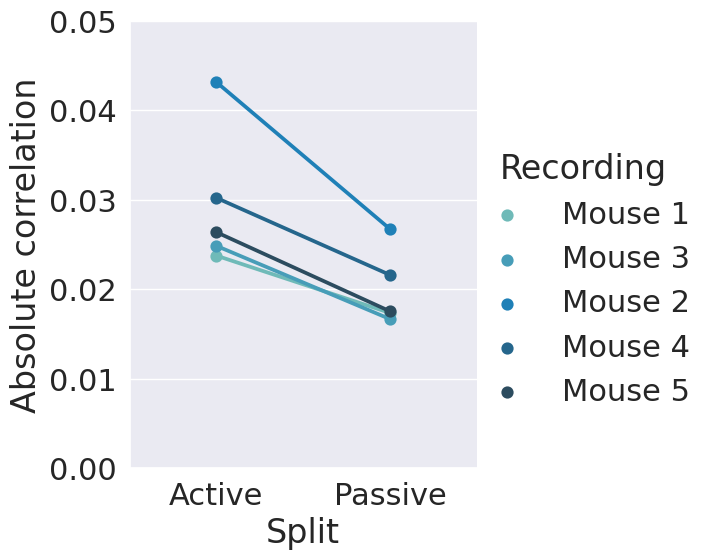

In [43]:
rm = results_df.melt(id_vars='session_id', value_vars=['active_cc', 'passive_cc',
                                                       'active_cs', 'passive_cs'])

rm[['Split', 'Type']] = rm['variable'].str.split('_', expand=True)
rm = rm.drop('variable', axis=1)
rm['Split'] = rm['Split'].str.capitalize()

# mouse mapping
rm = rm.replace({"session_id": mm})
rm = rm.rename(columns={"session_id": "Recording"})
sns.set(font_scale=2)

g = sns.catplot(
    data=rm.query('Type=="cs"'), x="Split", y="value", hue="Recording", # col="Type",
    capsize=.2, palette="YlGnBu_d",
    kind="point", height=6, aspect=1.0,
                )
plt.ylim((0,0.05))
plt.ylabel('Absolute correlation')

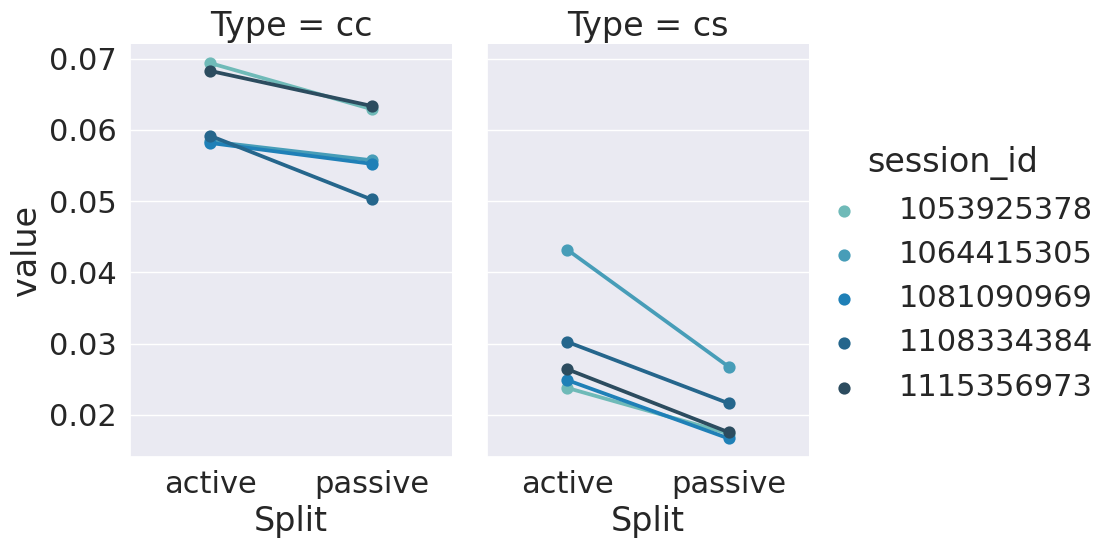

In [44]:
rm = results_df.melt(id_vars='session_id', value_vars=['active_cc', 'passive_cc',
                                                       'active_cs', 'passive_cs'])

rm[['Split', 'Type']] = rm['variable'].str.split('_', expand=True)
rm = rm.drop('variable', axis=1)

sns.set(font_scale=2)

g = sns.catplot(
    data=rm, x="Split", y="value", hue="session_id", col="Type",
    capsize=.2, palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
                )

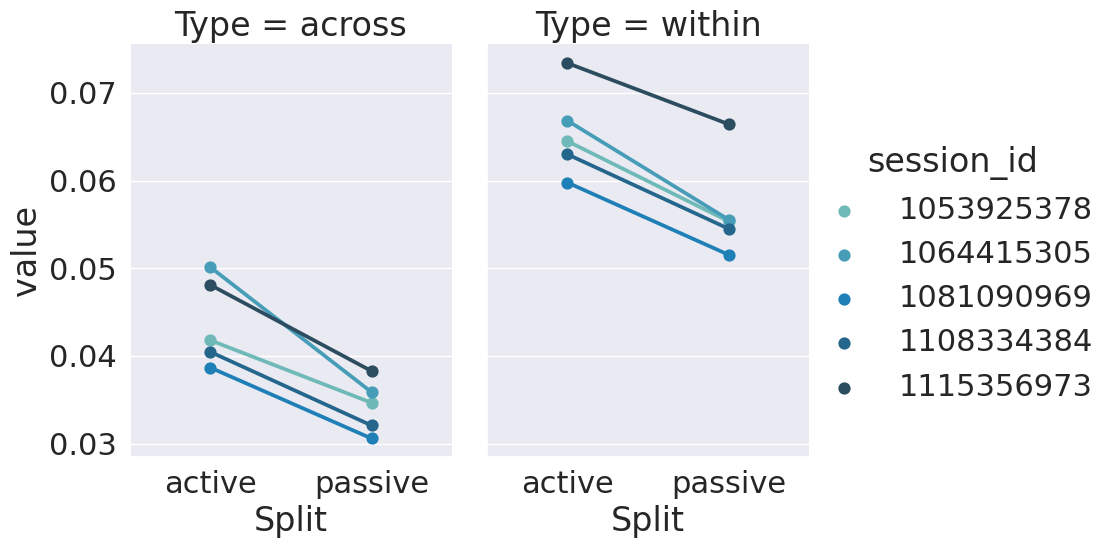

In [45]:
rm = results_df.melt(id_vars='session_id', value_vars=['active_across', 'passive_across',
                                                       'active_within', 'passive_within'])

rm[['Split', 'Type']] = rm['variable'].str.split('_', expand=True)
rm = rm.drop('variable', axis=1)

sns.set(font_scale=2)

g = sns.catplot(
    data=rm, x="Split", y="value", hue="session_id", col="Type",
    capsize=.2, palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
                )